###  Libraries

In [1]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.datasets import make_circles, make_moons
from sklearn.metrics.pairwise import pairwise_kernels
import matplotlib.pyplot as plt

from tslearn.clustering import KernelKMeans

from KernelKMeansPP import KernelKMeansPP

c:\Users\PAPASOFT INC\AppData\Local\Programs\Python\Python311\Lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


### Global Variables

In [2]:
seed = 42

### Load Dataset

In [3]:
n_samples = 500

X, y = make_circles(n_samples=n_samples, factor=0.2, noise=0.05, random_state=seed)
len(np.where(np.array(y) == 1)[0])

# Find indices of samples with label 1
indices_label_1 = np.where(np.array(y) == 0)[0]

# Define the number of samples to remove
num_samples_to_remove = 0

# Randomly select indices to remove
indices_to_remove = np.random.choice(indices_label_1, size=num_samples_to_remove, replace=False)

# Remove selected samples
X = np.delete(X, indices_to_remove, axis=0)
y = np.delete(y, indices_to_remove)

# Number of samples after removal
print("Number of samples after removal:", len(X))
#X, y = make_moons(n_samples=n_samples, noise=0.1, random_state=seed)

Number of samples after removal: 500


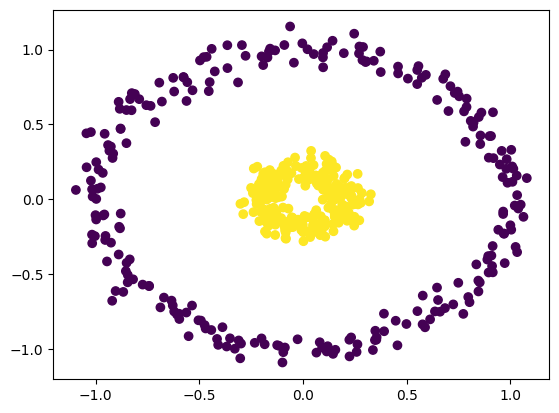

In [4]:
plt.scatter(X[:, 0], X[:, 1], c=y)

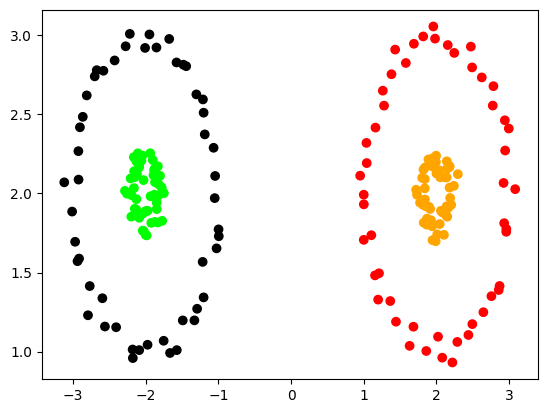

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from matplotlib.colors import ListedColormap

colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'black', 'cyan', 'gray', 'lime']

def make_n_circle_pairs(n_samples=100, factor=0.2, noise=0.05, random_state=None, center_positions=None):
    """
    Generate n pairs of X, y using make_circles function from scikit-learn with specified center positions and unique IDs for each ring.
    
    Parameters:
        n (int): Number of pairs to generate.
        n_samples (int): The total number of points generated.
        factor (float): Scale factor between inner and outer circle.
        noise (float): Standard deviation of Gaussian noise added to the data.
        random_state (int or RandomState instance): Random state or seed.
        center_positions (list of tuples): List of center positions for each pair. Each tuple should contain 
                                            the x-coordinate and y-coordinate of the center position.
        
    Returns:
        list: List of tuples containing X, y pairs.
    """
    pairs = []
    if center_positions is None:
        center_positions = [(0, 0)] * n  # Default center positions
    
    id = 0
    for _, center in enumerate(center_positions):
        X, y = make_circles(n_samples=n_samples, factor=factor, noise=noise, random_state=random_state)
        X[:, 0] += center[0]  # Adjust x-coordinate
        X[:, 1] += center[1]  # Adjust y-coordinate
        y = np.where(y == 0, id, id + 1)
        pairs.append((X, y))
        id += 2

    return pairs

# Generate 5 pairs of data with specified center positions and unique IDs for each ring
center_positions = [(2, 2), (-2, 2)]  # Specify center positions for each pair
pairs = make_n_circle_pairs(center_positions=center_positions)
X = np.concatenate([X for X, _ in pairs])
y = np.concatenate([y for _, y in pairs])

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=ListedColormap(colors))

In [6]:
K = 4
kernel_matrix = pairwise_kernels(X, X, metric='rbf', gamma=3)

c:\Users\PAPASOFT INC\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikit_learn-1.3.1-py3.11-win-amd64.egg\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


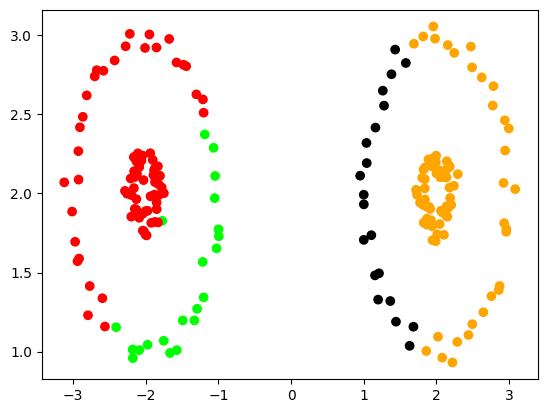

In [7]:
kmeans = KMeans(n_clusters=K).fit(X)
plt.scatter(X[:, 0], X[:, 1], c=kmeans.labels_, cmap=ListedColormap(colors))

c:\Users\PAPASOFT INC\AppData\Local\Programs\Python\Python311\Lib\site-packages\tslearn\utils\utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 200 1-dimensional timeseries
  warnings.warn(


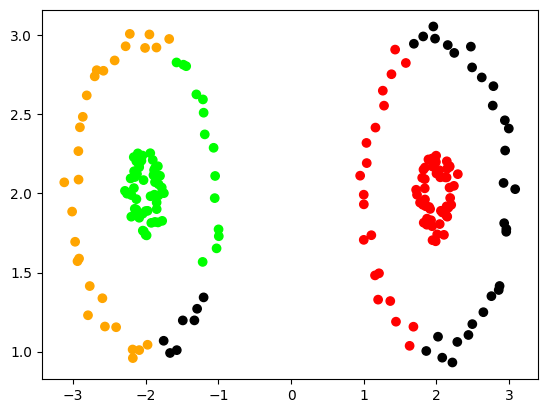

In [31]:
# Should find a way to init the fucking centers!
kernel_kmeans = KernelKMeans(n_clusters=K, n_init=1, kernel='precomputed').fit(kernel_matrix)
plt.scatter(X[:, 0], X[:, 1], c=kernel_kmeans.labels_, cmap=ListedColormap(colors))
plt.show()

Executing KkMeans++ Initialization
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]

 Total Error is: 128.1402371161935!
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]

 Total Error is: 123.37972619582558!
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]

 Total Error is: 120.25599193529075!
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]

 Total Error is: 116.42962741520023!
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]

 Total Error is: 111.12395455993348!
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]

 Total Error is: 107.41887840720051!
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]

 Total Error is: 105.0009866997239!

 Finished in 6 iterations!

 Total Error is: 105.0009866997239!
Executing KkMeans++ Initialization
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]

 Total Error is: 125.6431443133607!
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]

 Total Error is: 121.69284229809935!
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]

 Total Error is: 119.07956227279607!

 Finished in 2 iterations!

 Total Error is: 119.07956227279607!
Executing KkMeans++ In

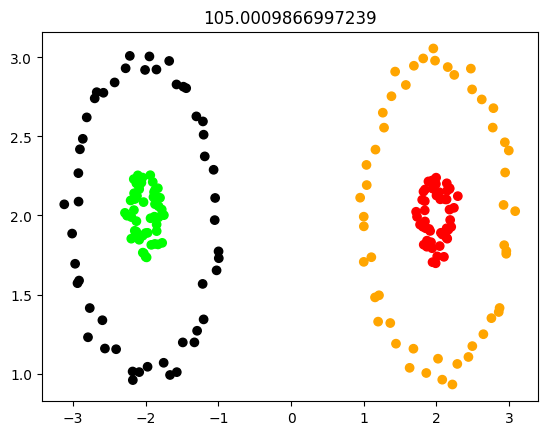

In [12]:
kernelKMeansPP =  KernelKMeansPP()
min_total_error, best_partition = kernelKMeansPP.kernel_kmeans_pp(X, K, kernel_matrix, n_init=100, method='KkMeans++')
plt.scatter(X[:, 0], X[:, 1], c=best_partition, cmap=ListedColormap(colors))
plt.title(min_total_error)
plt.show()